In [1]:
from pathlib import Path
freegroup_dimension = 4

path = Path('results', 'commutator-translation', f'{freegroup_dimension}-free-group')
path.mkdir(parents=True, exist_ok=True)

from os import environ
environ["CUDA_VISIBLE_DEVICES"] = "1"
environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
eos_token = '<s>'
pad_token = '<pad>'
comma_token = ','
left_bracket_token = '['
right_bracket_token = ']'

# DATA PREPARATION

## TOKENIZER

In [3]:

from tokenizers import Tokenizer
from tokenizers import (
    normalizers, pre_tokenizers, models, processors, trainers
)
from tokenizers.trainers import WordLevelTrainer

from itertools import chain

tokenizer = Tokenizer(models.WordLevel(
    vocab = {str(x): i for i, x in enumerate(chain(range(-freegroup_dimension, 0), range(1, freegroup_dimension + 1)))}
))
tokenizer.add_tokens([comma_token, left_bracket_token, right_bracket_token])
tokenizer.add_special_tokens([eos_token, pad_token])

tokenizer.pre_tokenizer = pre_tokenizers.Sequence([
    pre_tokenizers.WhitespaceSplit(),
])

tokenizer.post_processor = processors.TemplateProcessing(
    single=f"$ {eos_token}",
    special_tokens=[
        (eos_token, tokenizer.token_to_id(eos_token)),
    ]
)

tokenizer.save(str(path / 'tokenizer.json'))

## DATASET

In [2]:
from dataclasses import dataclass

@dataclass
class DatasetConfig:
    freegroup_dimension: int
    max_commutee_length: int
    max_commutator_depth: int
    proba_commutator: float
    proba_multiplication: float
    max_multipliers_number: int
    min_total_length: int
    max_total_length: int


In [3]:
from freegroup import sampling as smp
from freegroup.commutators import (
    Commutator, Multiplication,
    to_freegroup, normalize, to_tokenizer
)

from itertools import repeat
from random import randint, sample, random, shuffle

config = DatasetConfig(
    freegroup_dimension = freegroup_dimension,
    max_commutee_length = 3,
    max_commutator_depth = 7,
    proba_commutator = 0.85,
    proba_multiplication = 0.5,
    max_multipliers_number = 3,
    min_total_length = 0,
    max_total_length = 250,
)

from numpy.random import geometric

commutee = smp.free_group_bounded(config.freegroup_dimension, random_length_method = lambda : geometric(0.5))


def random_commutator(config: DatasetConfig, depth = None):

    depth = smp.random_length(config.max_commutator_depth, method="almost_uniform") if depth is None else depth

    if depth <= 0:
        return next(commutee)

    coin = random()
    if depth == 1 or coin < config.proba_commutator:
        depths = [randint(1, depth), depth]
        shuffle(depths)
        return Commutator(*[random_commutator(config, d - 1) for d in depths])
    coin -= config.proba_commutator
    
    if coin < config.proba_multiplication:
        depths = [randint(2, depth) for _ in range(randint(2, config.max_multipliers_number) - 1)] +\
            [depth]
        shuffle(depths)
        return Multiplication([random_commutator(config, d - 1) for d in depths])
    coin -= config.proba_multiplication


def commutators(config):
    while True: yield random_commutator(config)
        
generator = commutators(config)

generator = map(lambda x: (to_freegroup(x), x), generator)
generator = map(lambda p: tuple(map(normalize, p)), generator)

generator = filter(lambda p: not isinstance(p[1], list), generator)
generator = filter(lambda p: config.min_total_length < len(p[0]) < config.max_total_length, generator)

generator = map(lambda p: tuple(map(to_tokenizer, p)), generator)

visualize = list(smp.take_unique(1000, generator, verbose=True))


100%|██████████| 1000/1000 [00:01<00:00, 693.20it/s]


In [4]:
from freegroup.commutators import Visitor

class FindMultiplication(Visitor):
    def visit_word(self, word):
        return False

    def visit_commutator(self, commutator):
        return any(super().visit_commutator(commutator))

    def visit_mult(self, mult):
        return True
    
find_multiplication = FindMultiplication()


class MaxCommuteeLength(Visitor):
    def visit_word(self, word):
        return len(word)

    def visit_commutator(self, commutator):
        return max(super().visit_commutator(commutator))

    def visit_mult(self, mult):
        return max(super().visit_mult(mult))
    
max_commutee_length = MaxCommuteeLength()
    

class CalculateDepth(Visitor):
    def visit_word(self, word):
        return 0

    def visit_commutator(self, commutator):
        return max(super().visit_commutator(commutator)) + 1

    def visit_mult(self, mult):
        return max(super().visit_mult(mult)) + 1

calculate_depth = CalculateDepth()

HISTOGRAM "THE LENGTH OF A WORD"


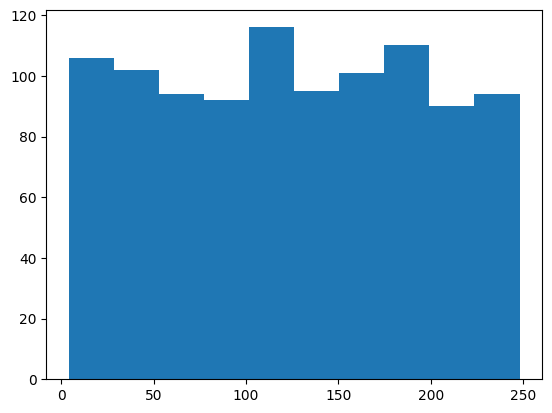

SCATTER PLOT "REDUCTION SIZE OF LENGTH"


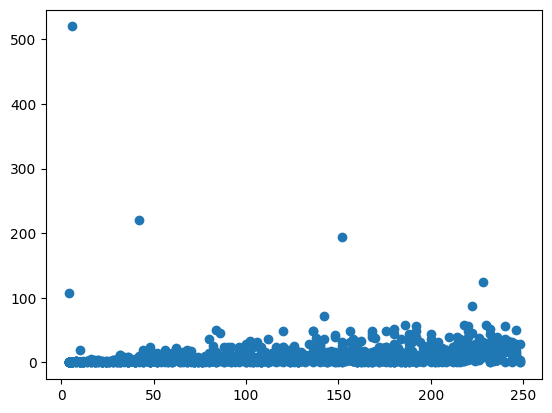

HISTOGRAM "COMMUTATOR DEPTH"


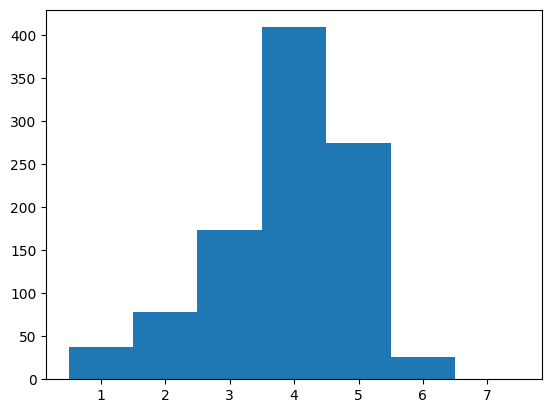

HISTOGRAM "MAX COMMUTEE LENGTH"


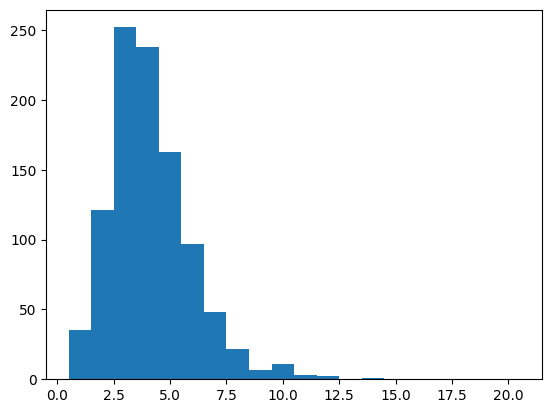

THE RATE OF WORDS CONTAINING MULTIPLICATION: 0.53


In [6]:
from freegroup.commutators import from_tokenizer

from matplotlib import pyplot as plt
from itertools import islice

freegroups = list(map(lambda x: from_tokenizer(x[0]), visualize))
commutators = list(map(lambda x: from_tokenizer(x[1]), visualize))

print('HISTOGRAM "THE LENGTH OF A WORD"')

lens = list(map(len, freegroups))
plt.hist(lens)
plt.show()

print('SCATTER PLOT "REDUCTION SIZE OF LENGTH"')

diffs = list(map(lambda x: len(to_freegroup(x[1])) - len(x[0]), zip(freegroups, commutators)))

plt.scatter(lens, diffs)
plt.show()

print('HISTOGRAM "COMMUTATOR DEPTH"')

from numpy import arange

depths = list(map(calculate_depth, commutators))
plt.hist(depths, arange(1, config.max_commutator_depth + 1.5) - 0.5)
plt.show()

print('HISTOGRAM "MAX COMMUTEE LENGTH"')

lengths = list(map(max_commutee_length, commutators))
plt.hist(lengths, arange(1, 20 + 1.5) - 0.5)
plt.show()

print(f'THE RATE OF WORDS CONTAINING MULTIPLICATION: {sum(map(find_multiplication, commutators)) / len(commutators)}')

In [44]:
dataset = list(smp.take_unique(int(2 * 10 ** 5), generator, verbose=True))

100%|██████████| 200000/200000 [04:52<00:00, 683.27it/s]


In [45]:
from pickle import dump

prefix = config.__str__().replace('DatasetConfig', '').replace('(', '').replace(')', '').replace(', ', ';')

with open(path / f'{prefix}.pkl', 'wb') as f:
    dump(dataset, f)

print(prefix)

freegroup_dimension=4;max_commutee_length=3;max_commutator_depth=7;proba_commutator=0.85;proba_multiplication=0.5;max_multipliers_number=3;min_total_length=0;max_total_length=250


# TRAINING

In [46]:
from transformers import PreTrainedTokenizerFast

tokenizer = PreTrainedTokenizerFast(
    tokenizer_file = str(path / 'tokenizer.json'),
    eos_token = eos_token,
    pad_token = pad_token
)

In [47]:
from pickle import load
from sklearn.model_selection import train_test_split

dataset_path = '...'

with open(dataset_path, 'rb') as f:
    dataset = load(f)

train_dataset, eval_dataset = train_test_split(dataset, test_size=0.01)

In [48]:
def preprocess(input):
    freegroup_seq, commutator_seq = input
    model_inputs = tokenizer(
        freegroup_seq,
        return_token_type_ids   = False,
        return_attention_mask   = False,
    )
    with tokenizer.as_target_tokenizer():
        model_targets = tokenizer(
            commutator_seq,
        )
    
    model_inputs['input_ids']   = model_inputs['input_ids']
    model_inputs['labels']      = model_targets['input_ids']

    return model_inputs


train_dataset = list(map(preprocess, train_dataset))
eval_dataset = list(map(preprocess, eval_dataset))

In [49]:
from transformers import BertConfig, GPT2Config, EncoderDecoderConfig, EncoderDecoderModel

encoder_config = BertConfig(
    vocab_size              = len(tokenizer),
    hidden_size             = 128,
    max_position_embeddings = 1024,
    num_hidden_layers       = 12,
    num_attention_heads     = 8,
    intermediate_size       = 4 * 128,
    pad_token_id            = tokenizer.pad_token_id,
)

decoder_config = BertConfig(
    vocab_size              = len(tokenizer),
    hidden_size             = 128,
    max_position_embeddings = 1024,
    num_hidden_layers       = 12,
    num_attention_heads     = 8,
    intermediate_size       = 4 * 128,
    pad_token_id            = tokenizer.pad_token_id,
)

config = EncoderDecoderConfig.from_encoder_decoder_configs(
    encoder_config = encoder_config,
    decoder_config = decoder_config,
)

model = EncoderDecoderModel(config=config)
model.config.decoder_start_token_id = tokenizer.eos_token_id
model.config.pad_token_id           = tokenizer.pad_token_id

In [50]:
from evaluate import load, combine

metrics = combine([load("bleu"), load("rouge")])


from re import finditer

def trim_eos_tokens(string):
    positions = finditer(eos_token, string)
    begin = next(positions).end()
    
    try:                    end = next(positions).start()
    except StopIteration:   end = len(string)

    return string[begin:end]


from numpy import argmax

def compute_metrics(eval_pred):
    logits, labels = eval_pred

    labels[labels == -100] = tokenizer.convert_tokens_to_ids(pad_token)

    predictions = tokenizer.batch_decode(logits, skip_special_tokens=False)
    references = tokenizer.batch_decode(labels, skip_special_tokens=False)
    references = list(map(lambda x: eos_token + ' ' +  x, references))
    
    predictions = list(map(trim_eos_tokens, predictions))
    references = list(map(trim_eos_tokens, references))

    print(predictions[0])
    print(references[0])


    return metrics.compute(references = references, predictions = predictions)

In [51]:
from typing import List
import torch

def data_collator(batch: List):
    def max_length_pad(batch: List):
        max_length = max(map(len, batch))
        batch = map(lambda x: x + [tokenizer.pad_token_id] * (max_length - len(x)), batch)
        batch = map(lambda x: torch.tensor(x, dtype=int), batch)
        batch = torch.stack(list(batch))
        
        attention_mask = torch.ones_like(batch)
        attention_mask.masked_fill_(batch == tokenizer.pad_token_id, 0.) 
        return batch, attention_mask
    
    input_ids, attention_mask = max_length_pad([x.input_ids for x in batch])
    labels, decoder_attention_mask = max_length_pad([x.labels for x in batch])
    labels[labels == tokenizer.pad_token_id] = -100
    
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels,
        'decoder_attention_mask': decoder_attention_mask,
    }


In [ ]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, DefaultDataCollator

prefix = 'bert-bert-250'

args = Seq2SeqTrainingArguments(
    output_dir                  = str(path/prefix),
    overwrite_output_dir        = True,

    predict_with_generate       = True,
    evaluation_strategy         = 'steps',
    eval_steps                  = 500,

    per_device_train_batch_size = 128,
    per_device_eval_batch_size  = 128,
    
    logging_steps               = 1000,
    save_steps                  = 1000,
    
    num_train_epochs            = 200,

    learning_rate               = 8e-5,

    generation_max_length       = 128,
)

trainer = Seq2SeqTrainer(
    model           = model,
    args            = args,
    train_dataset   = train_dataset,
    eval_dataset    = eval_dataset,
    data_collator   = data_collator,
    compute_metrics = compute_metrics,
)

trainer.train()

# REPOSITORY MANAGING

In [26]:
from huggingface_hub import Repository

repo = Repository('bert2bert-commutator-translator-250')

In [ ]:
model.save_pretrained('bert2bert-commutator-translator-250')
tokenizer.save_pretrained('bert2bert-commutator-translator-250')

repo.git_add()
repo.git_commit('Add model and tokenizer file')
repo.git_push()

# INFERENCE

In [3]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained(
    "kibrq/bert2bert-commutator-translator-250",
    eos_token = '</s>',
    pad_token = '<pad>',
)

model = AutoModelForSeq2SeqLM.from_pretrained("kibrq/bert2bert-commutator-translator-250").to('cuda')

In [6]:
from torch import tensor
from freegroup import tools, sampling as smp
from freegroup.commutators import (
    to_tokenizer, from_tokenizer
)
from itertools import repeat
from re import finditer
from itertools import islice


def sampler(word, **generation_kwargs):
    def sample():
        input_ids = tokenizer(
            to_tokenizer(word),
        ).input_ids
        input_ids = tensor(input_ids, dtype=int, device = model.device)
        outputs = model.generate(input_ids.unsqueeze(0), **generation_kwargs)
        return tokenizer.batch_decode(outputs)

    return sample


from re import finditer

def trim_eos_tokens(string):
    positions = finditer(tokenizer.eos_token, string)
    begin = next(positions).end()
    
    try:                    end = next(positions).start()
    except StopIteration:   end = len(string)

    return string[begin:end]


def try_or(callable, default, *args, **kwargs):
    try:
        return callable(*args, **kwargs)
    except BaseException:
        return default

def translation(
    word,
    num_tries = None,
    **generation_kwargs,
):
    g = smp.iterable_from_batches(sampler(
        word, **generation_kwargs 
    ), num_tries)
    g = map(trim_eos_tokens, g)
    g = map(lambda x: try_or(from_tokenizer, [], x), g)
    
    return filter(lambda x: normalize(to_freegroup(x)) == word, g)


In [7]:
from freegroup.commutators import (
    from_lu, normalize, to_freegroup, to_lu
)

generation_config = dict(
    max_length = 40,
    num_beams = 100,
    num_return_sequences = 100,
)

word = normalize(to_freegroup(from_lu('[[x, y], [x, yz]]')))

try:
    c = next(translation(word, num_tries = 5, **generation_config))
    print(to_lu(c))
except StopIteration:
    print('Failed!')

[[x,y],[x,yz]]
